In [111]:
%matplotlib inline
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

In [97]:
NUM_TRAIN_EXAMPLES = 300
X = np.zeros((NUM_TRAIN_EXAMPLES,10))

def get_time_feature(obj):
    hrs = obj.get("hours", 0)
    mins = obj.get("minutes", 0) / 60 + obj.get("seconds", 0) / 3600
    return hrs + mins

with open("10k.anon.json") as data: 
    iterations = 0
    for line in data:
        if iterations < NUM_TRAIN_EXAMPLES:
            vals = []
            obj = json.loads(line)
            for ts in obj["power"]:
                if ts["metric"] == "power":
                    vals.append(ts["value"])
                
            if vals == [] or max(vals) == 0:
                continue
                
            X[iterations, 0] = (max(vals) - min(vals)) / max(vals)
            X[iterations, 1] = np.std(vals)
            X[iterations, 2] = max(vals)
            X[iterations, 3] = min(vals) 
            X[iterations, 4] = get_time_feature(obj["job"]["wallclock_used"])
            X[iterations, 5] = obj["job"]["nodes_used"]
            X[iterations, 6] = obj["job"]["processors_used"]
            X[iterations, 7] = obj["job"]["mem_used"]
            X[iterations, 8] = obj["job"]["vmem_used"]
            X[iterations, 9] = obj["job"]["node_hours"]
            
            iterations += 1
        else:
            break
            
#print(X)

In [98]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
print(kmeans.labels_)

[0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0
 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 1 2 0 0 2 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 2 0 0 0 0 0 0 1 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 0 2
 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 2 0 0
 1 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2
 0 0 2 0 2 0 0 0 0 0 2 2 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0
 0 0 2 0]


In [102]:
gmm = GaussianMixture(n_components=2).fit(X)
print(gmm.predict(X))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0]


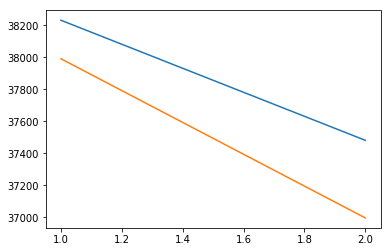

In [103]:
n_c = np.arange(1, 3)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_c]

plt.plot(n_c, [m.bic(X) for m in models], label='BIC')
plt.plot(n_c, [m.aic(X) for m in models], label='AIC')

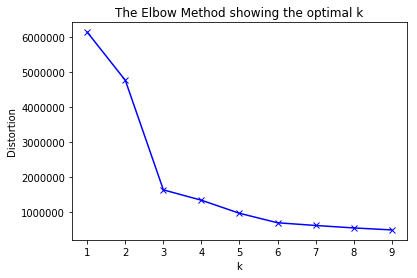

In [109]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [112]:
pca = PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

In [129]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
print(kmeans.labels_)

[0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0
 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 1 2 0 0 2 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 2 0 0 0 0 0 0 1 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 0 2
 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 2 0 0
 1 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2
 0 0 2 0 2 0 0 0 0 0 2 2 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0
 0 0 2 0]


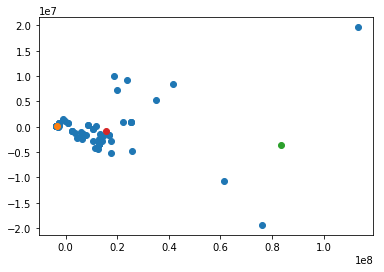

In [141]:
plt.scatter(X[:,0], X[:,1])
centers = kmeans.cluster_centers_
for c in range(len(centers[0])+1):    
    plt.scatter(centers[c][0], centers[c][1])

In [131]:
print(pca.explained_variance_ratio_) 

[ 0.96168714  0.03831286]
